# Proof-of-Concept Notebook

### 1. Title & Purpose

Description: 

    Predictive modeling proof-of-concept using Home Credit dataset.

The goal: 

    test whether engineered features and preprocessing can produce predictive models with strong ROC-AUC.

### 2. Assumptions & Objectives

**Key assumptions:**

    Banks care about early risk detection.
    
    Predictive power (ROC-AUC) is primary.
    
    Time to build matters; balance experimentation vs practicality.

**Objectives for the POC:**

    Train and evaluate baseline models.
    
    Incorporate engineered features.
    
    Compare model performance.
    
    Provide interpretable insights (feature importance, SHAP).
    
    Demonstrate deployable pipeline (even if only pseudo-code or high-level description).

### 3. Dataset Overview

**Quick summary of datasets used:**

application_train 
    
    - shape (307511 rows, 122 features (116 numeric, 16 categorical))
    - missingness ~97%

application_test 
    
    - shape (48744, 121 (115 numeric, 16 categorical))
    - missingness ~96%

bureau 
    
    - shape (1716428, 17 (numeric 14, categorical 3))
    - missingness 97.7%

bureau_balance 

    - shape (27299925, 3 (numeric 2, categorical 1))
    - missingness 97.7%

credit_card_balance 

    - shape (3840312, 23 (numeric 22, categorical 1))
    - missingness 21.5%,

previous_application

    - shape (1670214, 37 (numeric 8, categorical 0))
    - missingness 0.02%,

POS_CASH_balance 

    - shape (10001358, 8 (numeric 7, categorical 1)
    - missingness 0.26%,

installments_payments 

    - shape (13605401, 8 (numeric 19, categorical 17, boolean 1))
    - missingness 100%

    
    No duplicate records found across all datasets.


### 4. Preprocessing & Feature Engineering Summary

**Preprocessing steps applied (train/test)**

    Downcast numerics for memory efficiency.
    
    Handle date anomalies.
    
    Convert DAYS to YEARS for interpretability.
    
    Collapse rare categories.
    
    Add missing-value flags.
    
    Create/correct flags where needed.
    
    Build predictive domain-inspired features.


**Key engineered features:**

*Financial Ratios*

    Credit-to-annuity ratio, income-to-credit ratio, debt-to-income ratio - Capture applicant’s repayment capacity and leverage

*Asset Ownership*

    Asset score from owning a car or real estate - Proxy for financial stability

*Social Circle Default Rates*

    SOCIAL_30_DPD_RATE, SOCIAL_60_DPD_RATE - Peer-risk indicator: applicants surrounded by defaulters may be riskier

*Identity & Record Consistency*

    REGISTRATION_ID_DIFF: difference between registration year and ID publish year - Potential red flag for fraud or unstable records

*Housing Quality Score*

    Composite score from housing type and wall material - Reflects socio-economic living conditions

*Family Stress Indicator* 

    SINGLE_WITH_CHILDREN: applicants who are single but have dependents - Captures higher potential financial burden

*Strong predictors of applicant stability*

    External Risk Scores (most predictive baseline features) - EXT_SOURCE_1/2/3

*External dataset features*
    
*Flags for date anomalies*

### 5. Modeling

**Baseline models:**

    Logistic Regression, LightGBM, XGBoost, CatBoost, HistGradientBoosting,  Random Forest

**Models results**

In [2]:
import pandas as pd
%load_ext jupyter_black
model_comparison = pd.read_csv(r"../Data/model_comparison_results_preprocessed.csv")
model_comparison

,Model,ROC-AUC,F1-Score,PR-AUC,Time (seconds)
0,CatBoost,0.764432,0.275655,0.246248,1400.203547
1,XGBoost,0.763730,0.280639,0.247268,177.317691
2,LightGBM,0.762911,0.278623,0.247328,163.918247
3,HistGradientBoosting,0.761585,0.274544,0.243873,188.960103
4,Logistic Regresion,0.751932,0.263545,0.231742,2750.318458
5,Random Forest,0.743743,0.268555,0.223103,408.069132


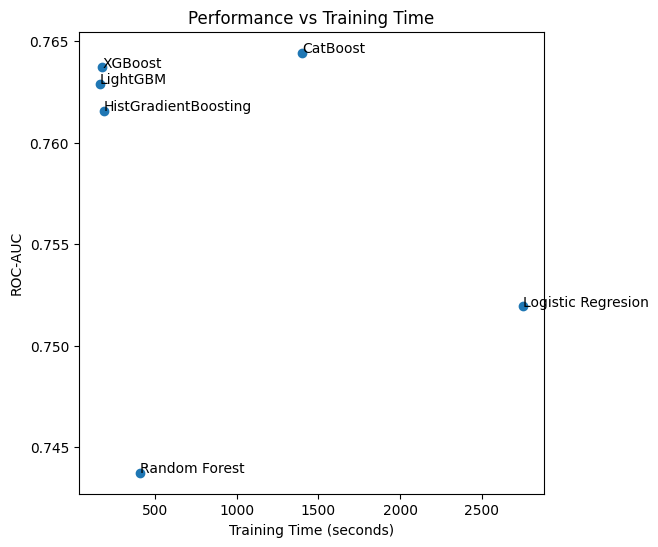

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(model_comparison["Time (seconds)"], model_comparison["ROC-AUC"])
for i, row in model_comparison.iterrows():
    plt.annotate(row["Model"], (row["Time (seconds)"], row["ROC-AUC"]))
plt.xlabel("Training Time (seconds)")
plt.ylabel("ROC-AUC")
plt.title("Performance vs Training Time")
plt.show()

Best 2 Models:

    1. LightGBM: Chosen for its near-top performance and exceptional speed.
    
    2. XGBoost: Selected for its slightly superior F1-Score and solid, stable performance.
    
    CatBoost is great but too computationally heavy here (10× slower for ~0.001 improvement).

**Feature selection strategy**
        
        Use LightGBM feature importance as the primary method.
        
        Select features with importance > 0, experiment with top-N (e.g., 140, 170, 200). The most optimal is the **top 170 features** which yielded a mean ROC-AUC score of 0.7856.

**Optuna results**

In [6]:
lgbm_best_result = pd.read_json(r"../Data/lgbm_best_result.json")
xgb_best_result = pd.read_json(r"../Data/xgb_best_result.json")
lgbm_best_result

,best_value,best_params
learning_rate,0.787908,0.040013
max_depth,0.787908,9.000000
min_child_samples,0.787908,644.000000
subsample,0.787908,0.687133
colsample_bytree,0.787908,0.602445


In [7]:
xgb_best_result

,best_value,best_params
learning_rate,0.78743,0.051778
max_depth,0.78743,4.000000
min_child_weight,0.78743,18.000000
subsample,0.78743,0.729937
colsample_bytree,0.78743,0.740587


### 6. Evaluation & Interpretation

**Baseline vs optimized models**
    
    LightGBM - 170 Selected Features after Optuna (comparison with results for 282 features before Optuna):
    
        ROC-AUC: 0.7881 (+0.0036)
        
        F1: 0.3016 (+0.0009)
        
        PR-AUC: 0.2784 (+0.0028)
        
        Time: 338s (-160s)

    XGBoost - 170 Selected Features after Optuna (282 features before Optuna):
    
        ROC-AUC: very small improvement 0.7863 (+ 0.0016).
        
        F1-score: slightly decreased 0.2975 (-0.0059).
        
        PR-AUC: almost unchanged 0.2767 (+ 0.0015).
        
        Training time: significantly reduced 318.43s (- 46s).

    Slight improvement across all metrics for LightGBM, and for some XGBoost metrics.

**Top 17 most important features for both models (SHAP)**

**Core Features**
    
    1. num__EXT_SOURCE_MEAN - Average of external credit bureau scores (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3).
    
    2. cat__CODE_GENDER - Gender of the client (Male / Female).
    
    3. num__AMT_ANNUITY - Loan annuity = fixed periodic payment (monthly installment).
    
    4. num__ANNUITY_TO_CREDIT - Ratio of annuity to credit amount.
    
    5. num__INSTAL_LATE_FLAG_mean - Average fraction of installments paid late (from installment payment history).
    
    6. num__LTV_RATIO - Loan-to-value ratio = (loan amount / goods price).
    
**Credit Behavior Features**
    
    7. num__BUREAU_CREDIT_UTILIZATION_max - Maximum credit utilization observed in bureau records.
    
    8. num__INSTAL_LATE_FLAG_sum - Total number of late installments (not normalized like the mean).
    
    9. num__EXT_SOURCE_2_3 - Feature engineering: interaction or aggregation between EXT_SOURCE_2 and EXT_SOURCE_3.
    
    10. cat__NAME_EDUCATION_TYPE - Client’s highest education level. Categories like Secondary, Higher, Academic degree.
    
    11. num__AMT_PAYMENT_sum - Total sum of payments made (from installment/payment history).

**Demographic / Employment Features**
    
    12. num__YEARS_EMPLOYED - Years employed at current job (converted from DAYS_EMPLOYED).
    
    13. num__YEARS_BIRTH - Client’s age (converted from DAYS_BIRTH).
    
    14. num__PREV_APP_CREDIT_RATIO_mean - From previous loan applications: average ratio of credit amount to requested amount.
    
    15. cat__NAME_FAMILY_STATUS - Family/marital status (Single, Married, Civil marriage, etc.).
    
    16. num__YEARS_ID_PUBLISH - Years since ID was issued (converted from DAYS_ID_PUBLISH).
    
    17. num__CNT_INSTALMENT_max -Maximum number of installments for any loan (loan length).

### 7. Ensembling

**Ensemble strategy** 
    
    weighted voting without calibration = LGBM - 0.7, XGB - 0.3 (Calibration improved recall, but at the cost of precision and ROC-AUC)

**Ensemble improvement**

    ROC_AUC - The ensemble model slightly outperforms the baseline (train set 0.7887 vs. LGBM 0.7881, on test set 0.7914 - no overfitting) 
        Kaggle result 0.7857 (LGBM 0.78515)

    Other metric nearly identical / slight improvement, but ensemble takes more than twice the time to run

**Confusion matrix on test set**

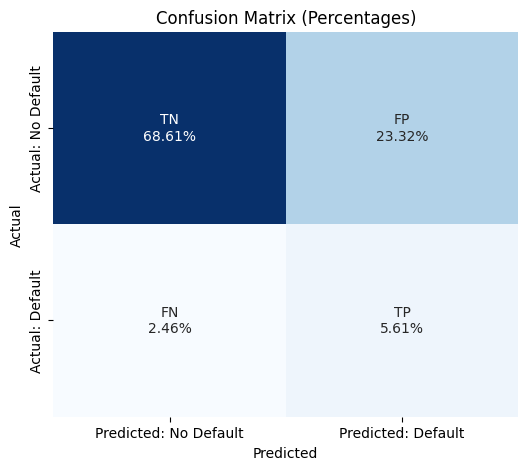

In [8]:
import seaborn as sns
import numpy as np

cm = np.array([[68.61, 23.32], [2.46, 5.61]])

labels = np.array([["TN\n68.61%", "FP\n23.32%"], ["FN\n2.46%", "TP\n5.61%"]])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted: No Default", "Predicted: Default"],
    yticklabels=["Actual: No Default", "Actual: Default"],
)

plt.title("Confusion Matrix (Percentages)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

    True Negatives (68.61%) - Correctly predicting non-default clients.
    
    False Positives (23.32%) - Predicting default where there isn’t one - costly for business if it rejects good clients.
    
    False Negatives (2.46%) - Default cases predicted as safe - this is the most dangerous error in credit risk.
    
    True Positives (5.61%) - Defaults correctly detected.
    
**Threshold optimization**

    Depending on clients need we could perform threshold optimization towards higher recal / lower precision:
        - decrease of false negative (FN) - giving a loan to a defaulter.
        - at higher cost of  false positive (FP) - rejecting a safe client.

### 8. Next Steps & Deployment

**Model & Pipeline Saving:**

    The final ensemble model (LightGBM and XGBoost), together with the preprocessing pipeline, was serialized using joblib and stored for inference. This ensures consistent transformations on future applicant data.

**Inference Flow:**

    Loaded model with preprocessing pipeline.
    
    The same feature engineering steps (financial ratios, asset ownership, social circle rates, etc.) was applied.
    
    Generated prediction probabilities for default risk.

**Deployment Options:**

    Lightweight API: Expose the pipeline through a REST API (e.g., FastAPI/Flask) for integration with banking systems.
    
    Containerization: Package model + preprocessing into a Docker container for portability.
    
    Cloud Deployment: Deploy to Google Cloud.

**Future Enhancements:**

    Implement probability calibration if the business needs well-calibrated risk scores.

    Conduct threshold optimization based on business-defined cost of false positives vs false negatives.

**Using the model** (Optional)

- Install and run RESTED Extension for Mozilla Firefox

- Input:

  Request

      POST / https://loan-prediction-api-153692760554.us-central1.run.app/predict

  Header

      Name: Content-Type, Value: application/json

  Request body

      Type:Custom

- Paste data (example)

{
    "application": [
        {
            "SK_ID_CURR": 100001,
            "DAYS_BIRTH": -12000,
            "AMT_INCOME_TOTAL": 100000,
            "AMT_CREDIT": 500000,
            "AMT_ANNUITY": 25000,
            "AMT_GOODS_PRICE": 450000,
            "NAME_INCOME_TYPE": "Working",
            "NAME_EDUCATION_TYPE": "Higher education",
            "NAME_FAMILY_STATUS": "Married",
            "NAME_HOUSING_TYPE": "House / apartment",
            "REGION_POPULATION_RELATIVE": 0.01,
            "DAYS_EMPLOYED": -2000,
            "DAYS_REGISTRATION": -3000,
            "DAYS_ID_PUBLISH": -1000,
            "OWN_CAR_AGE": 5,
            "CNT_FAM_MEMBERS": 3,
            "CNT_CHILDREN": 1
        }
    ],
    "bureau": [],
    "bureau_balance": [],
    "prev_app": [],
    "installments": [],
    "credit_card_balance": [],
    "pos_cash": []
}

- Run

      Send request

### 9. Key Results Summary

*Goal & Approach:*

    Built and compared multiple predictive models (LightGBM, XGBoost, CatBoost, etc.) to identify applicants at risk of default. Merged auxiliary datasets and applied feature engineering to improve predictive power.

*Top Models:*

    LightGBM and XGBoost achieved nearly identical ROC-AUC (~0.788), F1 (~0.30), and PR-AUC (~0.278) on 170 selected features after Optuna hyperparameter tuning. LightGBM is slightly slower but gives marginally better F1, while XGBoost is faster and equally robust.

*Ensemble Performance:*
    
    Weighted ensemble slightly improved ROC-AUC to 0.791 on the test set, demonstrating stability and strong generalization without overfitting. Kaggle result 0.7857 (single LGBM was 0.78515, XGB 0,78323)

*Key Predictors:*
    
    EXT_SOURCE_1/2/3, YEARS_BIRTH, YEARS_EMPLOYED, CODE_GENDER, AMT_ANNUITY are the strongest features driving predictions. SHAP analysis confirms consistent directional effects across models.

*Business Insight:*

    The model prioritizes high recall (aprox. 70% defaults detected) at the cost of precision (aprox. 23% false positives), aligning with credit risk priorities: catching risky clients is more critical than mistakenly flagging safe clients.